d:\Fake_Review_Detector\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Loading and Reprocessing Data ---

--- Data Ready ---

--- Starting Phase 4: Model Evaluation ---

Loading the trained model from 'fake_review_model.keras'...



TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
d:\Fake_Review_Detector\venv\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model loaded successfully.

Making predictions on the test data...
8/8 [==============================] - 46s 6s/step
Predictions complete.

--- Classification Report ---
              precision    recall  f1-score   support

 Genuine (0)       0.67      0.46      0.54        94
    Fake (1)       0.71      0.86      0.78       146

    accuracy                           0.70       240
   macro avg       0.69      0.66      0.66       240
weighted avg       0.70      0.70      0.69       240


--- Confusion Matrix ---


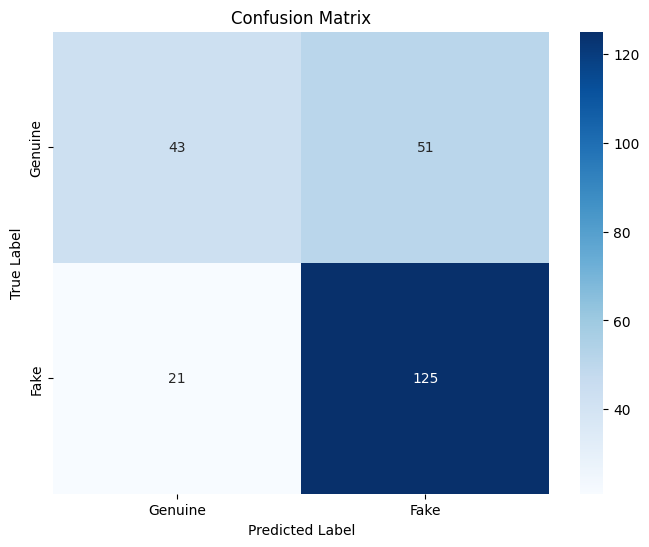


Phase 4 Complete! The results above show how well our model performs.


In [1]:
import pandas as pd
import os
import glob
import re
import numpy as np
import tensorflow as tf
# *** THE FIX IS HERE: Add TFAlbertModel to the import list ***
from transformers import AlbertTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Phase 1 & 2 Recap: Load and Preprocess Data ---
# This ensures this notebook can run independently.
print("--- Loading and Reprocessing Data ---\n")
# This is the corrected path
base_path = 'D:/Fake_Review_Detector/op_spam_v1.4/op_spam_v1.4'
# Load data
reviews = []
labels = []
for label_type in ['deceptive_from_MTurk', 'truthful_from_TripAdvisor']:
    for polarity in ['positive_polarity', 'negative_polarity']:
        path = os.path.join(base_path, polarity, label_type)
        files = glob.glob(os.path.join(path, 'fold*', '*.txt'))
        for file_path in files:
            with open(file_path, 'r', encoding='utf-8') as f:
                reviews.append(f.read())
                labels.append(1 if 'deceptive' in label_type else 0)
df = pd.DataFrame({'review': reviews, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Clean and Tokenize the data...
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text
df['cleaned_review'] = df['review'].apply(clean_text)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
tokenized_data = tokenizer(
    df['cleaned_review'].tolist(), padding=True, truncation=True, return_tensors='np', max_length=256
)
input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']
labels = np.array(df['label'].values)

# Re-create the exact same test split
_, X_test_ids, _, X_test_mask, _, y_test = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)
print("--- Data Ready ---\n")


# --- PHASE 4: EVALUATION ---
print("--- Starting Phase 4: Model Evaluation ---\n")

# 1. Load the Saved Model
print("Loading the trained model from 'fake_review_model.keras'...")
try:
    # *** THE FIX IS HERE: Tell Keras about our custom layer ***
    custom_objects = {'TFAlbertModel': TFAlbertModel}
    model = tf.keras.models.load_model('fake_review_model.keras', custom_objects=custom_objects)
    print("Model loaded successfully.\n")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# 2. Make Predictions on the Test Set
print("Making predictions on the test data...")
predictions_prob = model.predict([X_test_ids, X_test_mask])
predictions = (predictions_prob > 0.5).astype(int)
print("Predictions complete.\n")


# 3. Print the Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, predictions, target_names=['Genuine (0)', 'Fake (1)']))
print("="*50 + "\n")


# 4. Display the Confusion Matrix
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Genuine', 'Fake'],
            yticklabels=['Genuine', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nPhase 4 Complete! The results above show how well our model performs.")

